In [ ]:
#|default_exp warp

# Spatial versus spectral 

> Lasagna versus spaghetti  

In [ ]:
#|hide 
%load_ext autoreload
%autoreload 2 
%matplotlib notebook

In [ ]:
#|hide 
import os
import matplotlib.pyplot as plt

In [ ]:
#|hide 
os.chdir('/home/frank/Work/DATA/maxrf4u-data/')

In [ ]:
#|hide 
import numpy as np 
%matplotlib inline

In the previous sections we have converted and calibrated the original `.raw` spectral image data file into an analysis ready `.datastack` file. We will now gently start to learn how this three dimensional data cube is structured. Basically there are two ways to look at this data. One perspective is to think of the data cube as a stack of gray scale images. Every image has a different energy associated with it. If you remember from the previous section, these energies are the X-ray photon energies, expressed in kilo electron Volts (keV). Each image in the stack contains a distribution of intensities (photon counts). This is the lasagna view. 

Another way to think of the same data cube is to describe it as a rectangular bundle of spectra. At each spatial *(x,y)* location the data cube contains a spectrum with varying intensity along the third dimension *(z)* of the cube. This is the spaghetti view. We will come back to this in the next section.

Very roughly speaking, the spatial intensity distribution within a slice located at a specific peak energy band represents the spatial distribution of a certain chemical element. For a start we can take a look at the largest peak in the max spectrum. This peak in the energy range of 6.1-6.7 keV is caused by the presence of the chemical element iron in the drawing. Because it is the largest peak, is is called the Fe_Ka (alpha) peak. Without prior knowledge of XRF physics (we will get to this topic later on) we can compute peak slice map for this energy band.  

To do so, we need to read the required datasets with the `DataStack.read(<datapath>)` method. 

In [ ]:
from maxrf4u import DataStack 

In [ ]:
ds = DataStack('RP-T-1898-A-3689.datastack') 

x_keVs = ds.read('maxrf_energies')
y_max = ds.read('maxrf_maxspectrum') 
cube = ds.read('maxrf_cube', compute=False) # don't load into memory yet (too big)

is_iron_Ka_band = (x_keVs > 6.1) * (x_keVs < 6.7) 

In [ ]:
#|hide 
import matplotlib.pyplot as plt 

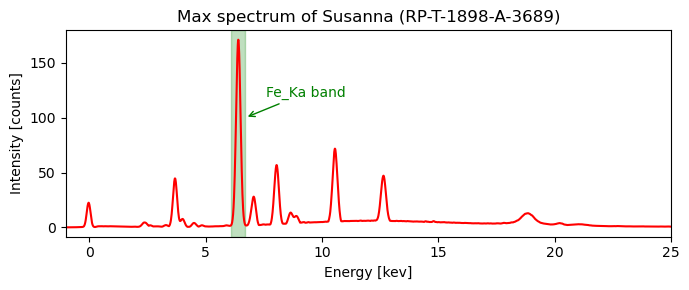

In [ ]:
#|echo: false  
fig, ax = plt.subplots(figsize=[7, 3])
ax.plot(x_keVs, y_max, color='r')
ax.set_xlim([-1, 25])
ax.set_xlabel('Energy [kev]')
ax.set_ylabel('Intensity [counts]')
ax.set_title('Max spectrum of Susanna (RP-T-1898-A-3689)') 

ax.fill_between(x_keVs, 0, 1, where=is_iron_Ka_band,
                color='green', alpha=0.25, transform=ax.get_xaxis_transform(), label='Fe_Ka')
ax.annotate('Fe_Ka band', xy=(6.7, 100),  xytext=(15, 15), textcoords='offset points', color='green', 
            arrowprops=dict(arrowstyle="->", color='green'))

plt.tight_layout()

We can now compute the iron distribution image by averaging over intensity at each pixel in the 60 images in the Fe_Ka energy band and plot the image. 

In [ ]:
#|hide 
np.sum(is_iron_Ka_band)

60

In [ ]:
FeKa_slice = cube[:,:,is_iron_Ka_band].compute() # load only this slice into memory 
FeKa_map = FeKa_slice.sum(axis=2) / 60 # average over number of channels in the Fe_Ka band 

In [ ]:
import matplotlib.pyplot as plt 

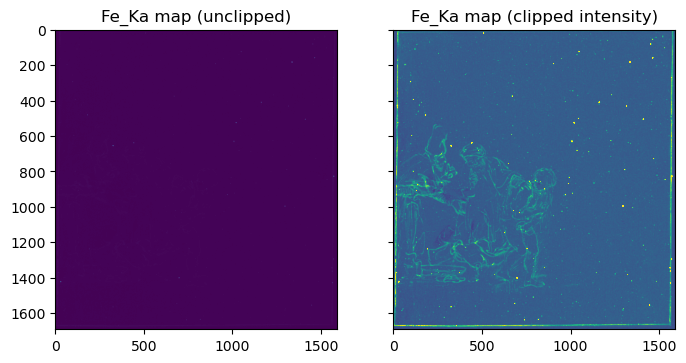

In [ ]:
fig, [ax, ax1] = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=[8, 5])

ax.imshow(FeKa_map);
ax.set_title('Fe_Ka map (unclipped)');
ax1.imshow(FeKa_map, vmax=2);
ax1.set_title('Fe_Ka map (clipped intensity)');

On the right we see here the distribution of iron associated with the iron-gall ink that Rembrandt used, as well as bright yellow speckles caused by iron particles present in the paper background. In order to make this visible, I had to clip the image intensity. On the left we see the very same image without clipping. Due to the high intensity of the iron speckles the contrast of the ink is very low.  

## Image registration helper 

Now, let's compare the iron distribution map with a photo of the drawing. In order to make such a comparison we need to register the two images. Fully automated registration of images is a very important capability that is unfortunately out of scope here. Instead I have created a four point warping function `warp()` that will do the job if we provide the corresponding corner points of both the source and destination image. These corner points can be be generated using the interactive `ImageRegistrationHelper()` function as shown below. This function displays interactive map widgets with markers that need to be positioned manually to corresponding landmarks on both the source (left) and destination (right) image. in our situation it is preferred to warp the visible image onto the iron map. 

In [ ]:
#|code-fold: true   
susanna_highres_file = 'RP-T-1898-A-3689_highres.png'
susanna_highres = plt.imread(susanna_highres_file)

src_im = susanna_highres
dst_im = np.clip(FeKa_map, a_min=0, a_max=2) 

In [ ]:
from maxrf4u import ImageRegistrationHelper

In [ ]:
imreg = ImageRegistrationHelper(src_im, dst_im)
imreg.show()

<img src="images/animation-ImageRegistrationHelper.gif">

To register both images you first need to drag all eight markers to pairwise corresponding locations. When positioned correctly you can print the actual positions of the markers with the `.get_marker_coordinates()` method. 

In [ ]:
src_points, dst_points = imreg.get_marker_coordinates();

src_points = [[78.5, 204.6], [4340.1, 180.4], [4376.99, 4724.0], [110.1, 4766.3]]
dst_points = [[24.7, 7.64], [1579.0, 10.2], [1563.8, 1666.0], [8.22, 1671.92]]


Given the corresponding source and destination marker points, the source image can be warped (registered) onto the destination image using the `warp()` function. 

In [ ]:
#|code-fold: true  
susanna_highres_file = '/home/frank/Work/Projecten/DoRe/data/drawings/rma-web-highres/RP-T-1898-A-3689_highres.png'
susanna_highres = plt.imread(susanna_highres_file)

src_im = susanna_highres
dst_im = FeKa_map 

# corner points for image registration 
src_points = [[78.5, 204.6], [4340.1, 180.4], [4376.99, 4724.0], [110.1, 4766.3]]
dst_points = [[24.7, 7.64], [1579.0, 10.2], [1563.8, 1666.0], [8.22, 1671.92]]

In [ ]:
from maxrf4u import warp  

In [ ]:
imvis_reg_highres, extent = warp(src_im, dst_im, src_points, dst_points, rgba=False)
imvis_reg, extent = warp(im_src, im_dst, pts_src, pts_dst, keep_scale=False, rgba=False)

For future calculations we will store the registered images and their extent in our `.datastack` file, using the `append()` function. In our further analysis we can simply use the registered images with the DataStack.read() method. 

In [ ]:
from maxrf4u import append 

In [ ]:
append(imvis_reg, 'imvis_reg', 'RP-T-1898-A-3689.datastack')
append(imvis_reg_highres, 'imvis_reg_highres', 'RP-T-1898-A-3689.datastack')
append(extent, 'imvis_extent', 'RP-T-1898-A-3689.datastack')

In [ ]:
#|code-fold: true 
ds = DataStack('RP-T-1898-A-3689.datastack')

extent = ds.read('imvis_extent')
imvis_reg_highres = ds.read('imvis_reg_highres')

fig, [ax, ax1] = plt.subplots(ncols=2, figsize=[7, 4], sharex=True, sharey=True)

ax.imshow(FeKa_map, vmax=2)
ax1.imshow(imvis_reg_highres, extent=extent);

..

Nicely registered!

## FUNCTIONS 

In [ ]:
#|export 

from ipywidgets import Layout, HBox, VBox 
#import ipywidgets 

from ipyleaflet import Map, ImageOverlay, Marker, DivIcon, FullScreenControl, projections

#from ipyleaflet import Map, Marker, projections, ImageOverlay, FullScreenControl, DivIcon

from ipywidgets import Layout, GridBox, VBox, HBox, jsdlink 
from ipywidgets.embed import embed_minimal_html 
  
import io 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import base64 
import skimage.transform as skt 
import imageio.v2 as imageio 
import skimage.transform as skt

import numpy as np
import cv2 

In [ ]:
#|export     
class ImageRegistrationHelper(object): 
    '''Create interactive image registration. '''
    
    def __init__(self, src_im, dst_im, src_points=None, dst_points=None, scale_down=True): 
        
         
        # image shapes 
        src_h, src_w = self.src_h, self.src_w = src_im.shape[0:2]
        dst_h, dst_w = self.dst_h, self.dst_w = dst_im.shape[0:2]
        
        
        # scale base64 image down to smallest width 
        if  scale_down is True: 
            max_width = min([src_w, dst_w]) 
        else: 
            max_width = None 
        
        # create base64 urls 
        src_url = _img_to_base64_url(src_im, max_width=max_width)
        dst_url = _img_to_base64_url(dst_im, max_width=max_width)
        
        # create custom colored icons
        w, h = 60, 20
        colors = ['orange', 'green', 'red', 'blue'] 
        markers_html = [f"""<svg width="60px", height="45px">
                <polygon points="20,25 40,25 30,40" style="fill:{col};stroke:white;stroke-width:1" />
                <text x="10" y="12" font-size="10" fill="black">Drag me</text>
                </svg>""" for col in colors] 
        icons = [DivIcon(html=html, bg_pos=(0, 0), icon_anchor=[30, 40], icon_size=[w, h]) for html in markers_html]

        # prepare src and dst markers 
        self._src_markers = [] 
        self._dst_markers = [] 
        
        src_locations = xy_to_latlon(imshape=[src_h, src_w], xy_points=src_points) 
        dst_locations = xy_to_latlon(imshape=[dst_h, dst_w], xy_points=dst_points) 

        # calculate map src and dst zoom levels to fit bounds (leaflet tiles are 256 pixels)
        # see: https://leafletjs.com/examples/zoom-levels/ 
        src_zoom = -max([np.log2(np.ceil(src_w / 256)), np.log2(np.ceil(src_h / 256))]) - 2
        dst_zoom = -max([np.log2(np.ceil(dst_w / 256)), np.log2(np.ceil(dst_h / 256))]) - 2 
        
        # create source maps for each corner 
        map_layout = Layout(height='200px', width='200px')
        src_maps = []
        for i, location in enumerate(src_locations):  
            m = Map(center=[src_h/2, src_w/2], zoom=src_zoom+1, crs=projections['Simple'],  layout=map_layout, 
                    scroll_wheel_zoom=True, min_zoom=src_zoom-2, interpolation='nearest')

            imo = ImageOverlay(url=src_url, bounds=[[-0.5, -0.5], [src_h - 0.5, src_w - 0.5]]) # bounds= SW NE corners
            mrk = Marker(location=location, draggable=True, title='Drag me to landmark', icon=icons[i])
            fsc = FullScreenControl()

            m.add(imo)
            m.add(fsc)
            m.add(mrk)

            self._src_markers.append(mrk)

            m.remove(m.layers[0]) # hack to remove world map 
            src_maps.append(m)
            
        # create dst maps for each corner 
        dst_maps = []    
        for j, location in enumerate(dst_locations):  
            m = Map(center=[dst_h/2, dst_w/2], zoom=dst_zoom+1, crs=projections['Simple'],  layout=map_layout, 
                    scroll_wheel_zoom=True, min_zoom=dst_zoom-2, interpolation='nearest')

            imo = ImageOverlay(url=dst_url, bounds=[[-0.5, -0.5], [dst_h - 0.5, dst_w - 0.5]]) # bounds= SW NE corners
            mrk = Marker(location=location, draggable=True, title='Drag me to landmark', icon=icons[j])
            fsc = FullScreenControl()

            m.add(imo)
            m.add(fsc)
            m.add(mrk)

            self._dst_markers.append(mrk)

            m.remove(m.layers[0]) # hack to remove world map 
            dst_maps.append(m)
        
        # sync map widgets centers to marker locations  
        # not exactly what I want, but close 
        # need probably something like a callback function on_drag or zoom  
        # too complicated for now 
        #if center_markers: 
        #    for  mrk, mp in zip(self._src_markers, src_maps): 
        #        jsdlink([mrk, 'location'],[mp, 'center'])
        #
        #    for  mrk, mp in zip(self._dst_markers, dst_maps): 
        #        jsdlink([mrk, 'location'],[mp, 'center'])
        #           
        # combine maps     

        src_hbox = HBox(src_maps)
        dst_hbox = HBox(dst_maps)
        
        self._vbox = VBox([src_hbox, dst_hbox])
        
    def show(self): 

        return self._vbox 
    
    
    def get_marker_coordinates(self, verbose=True): 
        '''Extract marker point coordinates from widget. '''
        
        src_locations = [mrk.location for mrk in self._src_markers]
        dst_locations = [mrk.location for mrk in self._dst_markers]
        
        src_points = latlon_to_xy([self.src_h, self.src_w], src_locations)
        dst_points = latlon_to_xy([self.dst_h, self.dst_w], dst_locations)
        
        src_points = np.round(src_points, decimals=2).tolist()
        dst_points = np.round(dst_points, decimals=2).tolist()
        
        if verbose: 
            print(f'src_points = {src_points}')
            print(f'dst_points = {dst_points}')
               
        return src_points, dst_points 
    
        
        
def _img_to_base64_url(img_data, max_width=None): 
    '''Filename or numpy array *img_data* is transformed into 256 bit color compressed base64 encoded url string. 
    
    To reduce image size specify thumbnail `max_width`. 
    
    Returns: url_string'''
        
    #try: 
    #    # better than matplotlib use skimage.io.imread to avoid float64 explosion...
    #    img = imageio.imread(img_data) # if img_data is an image file path 
    #except: 
    #    img = img_data # otherwise assume img_data is an image like numpy array 
    img = img_data 

    # rescaling image if width > max_width 
    # TODO: better testing 
    h, w = img.shape[0:2] 
    if max_width is not None:  
        if w > max_width:
            scale = max_width / w 
            # scalar image 
            if img.ndim == 2: 
                channel_axis = None
            else: 
                channel_axis = 2
            img = skt.rescale(img, scale, channel_axis=channel_axis) #, multichannel=True) deprecated 
    # apply color map if single channel image
    sm = cm.ScalarMappable()
    sm.set_clim(vmin=None, vmax=None)
    rgba = sm.to_rgba(img, bytes=True)

    # convert to base64 string via memory buffer 
    buff = io.BytesIO();
    imageio.imsave(buff, rgba, format='png')
    base64_string = base64.b64encode(buff.getvalue()).decode("ascii")
    url_string = f'data:image/png;base64,{base64_string}' 
    
    # let's close buffer just in case
    buff.close() 

    return url_string 

        
def warp(im_src, im_dst, pts_src, pts_dst, keep_scale=True, rgba=True, alpha_color=[1, 0, 0]): 
    '''Opencv based homographic registration. Can return transparent overlay (rgba). 
    
    Returns: *im_warped*, *extent* '''

    src_h, src_w = im_src.shape[0:2]
    dst_h, dst_w = im_dst.shape[0:2]
    
    if keep_scale: 
        scale = src_h / dst_h 
    else: 
        scale = 1

    # calculate homography 
    hom, status = cv2.findHomography(pts_src, scale * pts_dst)

    # Size is nearest integer scaled (width,height) of im_dst
    size = round(scale * dst_w), round(scale * dst_h)
    
    # warp im_src onto destination 
    im_warped = cv2.warpPerspective(im_src, hom, size) 
    
    # warp white onto destination to create mask 
    mask_src = np.ones([src_h, src_w])
    mask_warped = cv2.warpPerspective(mask_src, hom, size) 
    
    # calculate extent for plotting 
    h, w = im_dst.shape[0:2] 
    extent =  (0, w, h, 0) 
    
    # convert into rgba image  
    if rgba is True: 
        im_rgba = np.ones([h, w, 4])

        # for single channel image 
        if len(im_src.shape) == 2:
            # colorize
            im_rgba[:,:,0:3] = alpha_color[0:3] 
            #  make alpha layer 
            im_rgba[:,:,3] = im_warped 
            
        # otherwise assume image is rgb
        elif len(im_warped.shape) == 3: 
            
            # rgb channels
            im_rgba[:,:,0:3] = im_warped[:,:,0:3]
            # alpha channels 
            im_rgba[:,:,3] = mask_warped
       
        im_warped = im_rgba 
    
    return im_warped, extent  


# coordinate transformations 

def xy_to_latlon(imshape, xy_points=None): 
    '''Flip and exchange list with xy `points` into list of latitude-longitude locations. 
    
    If `xy_points` are not specified, locations of the four image corner are returned. 
    
    Returns: locations '''
    
    h, w = imshape 
    
    # use image corners (pixel centric coordinates) 
    if xy_points is None:     
        xy_points = [[0, 0], [w - 1, 0], [0, h - 1], [w - 1, h - 1]]
    
    xy_points = np.array(xy_points) # cast to numpy array if list
    xy_points[:,1] = h - 1 - xy_points[:,1] # flip y 
    
    locations = xy_points[:,::-1] # exchange x <-> y 
    
    locations = locations.tolist() # Marker() expects list instead of array 

    return locations 


def latlon_to_xy(imshape, locations): 
    '''Flip and exchange list with latitude-longitude `locations` into list of xy_points. 
    
    Returns: xy_points '''
    
    h, w = imshape 
    
    locations = np.array(locations) # cast to numpy array if list 
    locations[:,0] = h - 1 - locations[:,0] # flip y  
    
    xy_points = locations[:,::-1] # exchange x <-> y 

    return xy_points

#|hide 

## Issues

* Need a fast and user friendly way to inspect and improve and existing image registration. 
* Add option to select base64 encoding or python matplotlib?
* Would be better to create a separate package (one day)